In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set()
%matplotlib inline

In [2]:
repo_url = 'https://raw.githubusercontent.com/Xiaoqi-Sun/aptamer_scoring/main/'

# raw data
for i in np.arange(2,7):
    exec("R{}E = pd.read_csv(repo_url+'serotonin%20raw%20data/{}RE.csv')".format(i, i))
    exec("R{}C = pd.read_csv(repo_url+'serotonin%20raw%20data/{}RC.csv')".format(i, i))
    
# processed data
for i in np.arange(2,7):
    exec("R{}E_frequency = pd.read_csv(repo_url+'serotonin%20processed%20data/R{}E_frequency.csv',index_col='Quadrumer')".format(i, i))
    exec("R{}C_frequency = pd.read_csv(repo_url+'serotonin%20processed%20data/R{}C_frequency.csv',index_col='Quadrumer')".format(i, i))
    exec("R{}E_full_table_weighted = pd.read_csv(repo_url+'serotonin%20processed%20data/R{}E_full_table_weighted.csv',index_col=0)".format(i, i))
    exec("R{}C_full_table_weighted = pd.read_csv(repo_url+'serotonin%20processed%20data/R{}C_full_table_weighted.csv',index_col=0)".format(i, i))

In [3]:
# experimental dF/F values

# round 1: Sanghwa's 80 sequences
dFF = pd.read_csv(repo_url+'dFF%20data/dFF_r1.csv',usecols=[0,1,2])

# round 2: Xiaoqi's Prediction
dFF2_new = pd.read_csv(repo_url+'dFF%20data/dFF_r2_new.csv')

# round 3: Payam's prediction
dFF3_new = pd.read_csv(repo_url+'dFF%20data/dFF_r3_new.csv',usecols=[0,1,3]).rename(columns={'dFF_1195':'dFF'}) #use dFF value at 1195nm

# round 4: Payam's  prediction (Model 3)
dFF4_pos = pd.read_csv(repo_url+'dFF%20data/dFF_r4_positive.csv')
dFF4_neg = pd.read_csv(repo_url+'dFF%20data/dFF_r4_negative.csv')

dFF_combined = dFF.append(dFF2_new).append(dFF3_new).append(dFF4_pos).append(dFF4_neg)

In [4]:
# general function for calculating quad score

def max_freq_ratio(quad_seq):
    #find the last term of the score definition
    r2=R2E_frequency[R2E_frequency.index==quad_seq]['Weighted frequency'][0] if quad_seq in R2E_frequency.index else 0
    r3=R3E_frequency[R3E_frequency.index==quad_seq]['Weighted frequency'][0] if quad_seq in R3E_frequency.index else 0
    r4=R4E_frequency[R4E_frequency.index==quad_seq]['Weighted frequency'][0] if quad_seq in R4E_frequency.index else 0
    r5=R5E_frequency[R5E_frequency.index==quad_seq]['Weighted frequency'][0] if quad_seq in R5E_frequency.index else 0      
    r6=R6E_frequency[R6E_frequency.index==quad_seq]['Weighted frequency'][0]
    
    # handle the inf case
    r6r5 = 0 if r5==0 else r6/r5
    r5r4 = 0 if r4==0 else r5/r4
    r4r3 = 0 if r3==0 else r4/r3
    r3r2 = 0 if r3==0 else r3/r2
    return max(r3r2,r4r3,r5r4,r6r5)

def max_freq_ratio_ctrl(quad_seq):
    #find the last term of the score definition
    r2=R2C_frequency[R2C_frequency.index==quad_seq]['Weighted frequency'][0] if quad_seq in R2C_frequency.index else 0
    r3=R3C_frequency[R3C_frequency.index==quad_seq]['Weighted frequency'][0] if quad_seq in R3C_frequency.index else 0
    r4=R4C_frequency[R4C_frequency.index==quad_seq]['Weighted frequency'][0] if quad_seq in R4C_frequency.index else 0
    r5=R5C_frequency[R5C_frequency.index==quad_seq]['Weighted frequency'][0] if quad_seq in R5C_frequency.index else 0      
    r6=R6C_frequency[R6C_frequency.index==quad_seq]['Weighted frequency'][0]
    
    # handle the inf case
    r6r5 = 0 if r5==0 else r6/r5
    r5r4 = 0 if r4==0 else r5/r4
    r4r3 = 0 if r3==0 else r4/r3
    r3r2 = 0 if r3==0 else r3/r2
    
    return max(r3r2,r4r3,r5r4,r6r5)

def extract_quadrumers(aptamer_sequence):
    #takes in one 18-mer and return a table of quadrumers, with a position column and a quadrumer column
    quadrumers = []
    for i in np.arange(15):
        quad = aptamer_sequence[i:i+4]
        quadrumers = np.append(quadrumers,quad)
    return quadrumers


def quad_score_exp(set_1_percentile, exp_ind_weight, name):
    #inputs: set_1_percentile -> see definition of set 1; {exp,ctrl}weight: weight for two indicator functions
    #return a dataframe with quadrumer as index and weighted frequency and scores as two columns
    #using quadrumers in R6E for calculation 
    
    #set 1: Kmers with frequencies once greater than 99.5th percentile of the kmers in the control round
    control_percentile = np.percentile(R2E_frequency['Weighted frequency'], set_1_percentile)
    set1 = R6E_frequency[R6E_frequency['Weighted frequency']>control_percentile]
    set1_list = set1.index

    #set 2: : with the same class size and consisting of kmers with the largest amplification-fold values was then defined. 
    set2 = R2E_frequency.merge(R6E_frequency,on='Quadrumer').rename(columns={'Weighted frequency_x':'R2E freq', 'Weighted frequency_y':'R6E freq'})
    set2['amp-fold value'] = set2['R6E freq']/set2['R2E freq']
    set2 = set2.sort_values('amp-fold value', ascending=False).head(len(set1))
    set2_list = set2.index
    
    score_r6 = []
    for i in R6E_frequency.index:
        term1 = (i in set1_list) or (i in set2_list)
        term2 = (i in set1_list)
        term3 = max_freq_ratio(i)
        score_r6 = np.append(score_r6, term1*exp_ind_weight + term2*exp_ind_weight + term3)
        
    R6E_with_score = R6E_frequency.copy()
    R6E_with_score[name+'_exp'] = score_r6
    return R6E_with_score

def quad_score_ctrl(set_1_percentile, ctrl_ind_weight, name):
    #return a dataframe with quadrumer as index and weighted frequency and scores as two columns
    #using quadrumers in R6E for calculation 
    
    #set 1 NOTE: using 99.5 percentile only gives 3 quadrumers
    control_percentile = np.percentile(R2C_frequency['Weighted frequency'],set_1_percentile) 
    set1 = R6C_frequency[R6C_frequency['Weighted frequency'] > control_percentile]
    set1_list = set1.index
    
    #set 2: : with the same class size and consisting of kmers with the largest amplification-fold values was then defined. 
    set2 = R2C_frequency.merge(R6C_frequency,on='Quadrumer').rename(columns={'Weighted frequency_x':'R2C freq', 'Weighted frequency_y':'R6C freq'})
    set2['amp-fold value'] = set2['R6C freq']/set2['R2C freq']
    set2 = set2.sort_values('amp-fold value', ascending=False).head(len(set1))
    set2_list = set2.index
    
    score_r6 = []
    for i in R6C_frequency.index:
        term1 = (i in set1_list) or (i in set2_list)
        term2 = (i in set1_list)
        term3 = max_freq_ratio_ctrl(i)
        score_r6 = np.append(score_r6, term1*ctrl_ind_weight + term2*ctrl_ind_weight + term3)
        
    R6C_with_score = R6C_frequency.copy()
    R6C_with_score[name+'_ctrl'] = score_r6
    return R6C_with_score

def quad_score_full(set_1_percentile_exp, set_1_percentile_ctrl, exp_ind_weight, ctrl_ind_weight, exp_weight, ctrl_weight, name):
    quad_exp = quad_score_exp(set_1_percentile_exp, exp_ind_weight, name)
    quad_ctrl = quad_score_ctrl(set_1_percentile_ctrl, ctrl_ind_weight, name)
    
    merged = quad_exp.merge(quad_ctrl, how='left', left_index=True, right_index=True)
    
    merged[name] = exp_weight*merged[name+ '_exp'] - ctrl_weight*merged[name+'_ctrl']
    return pd.DataFrame({'Weighted frequency': merged['Weighted frequency_x'], #weighted frequence is from R6E
                        name : merged[name] })

In [5]:
# general functions for calculating aptamer score 

def aptamer_score(RnE, quad_score, name):
    # Returns a dataframe like R6E, with 18-mer sequence and score for each aptamer
    # Inputs: RnE: a dataframe with 18-mer sequences;
    #        quad_score: a df , out put of quad_score_full function,
    
    quadrumer_score = quad_score
    score_name = quadrumer_score.columns[1]
    
    aptamer_score = []
    aptamer_freqsum = []
    for apt_seq in RnE['Trimed']:
        all_quads = extract_quadrumers(apt_seq)
        one_score = 0
        one_freqsum = 0
        for quad in all_quads:
            if len(quadrumer_score[quadrumer_score.index==quad]) != 0:
                one_score += quadrumer_score.loc[quad][1]
                one_freqsum += quadrumer_score.loc[quad][0]
        aptamer_score = np.append(aptamer_score, one_score)
        aptamer_freqsum = np.append(aptamer_freqsum, one_freqsum)
        
    tbl_with_score = RnE.copy().loc[:,['Trimed']]
    tbl_with_score[name]=aptamer_score
    tbl_with_score['Weighted frequency'] = aptamer_freqsum
    tbl_with_score.index = tbl_with_score.index + 1 # reset index to match!
    
    
    tbl_with_score[name+' percent'] = 100*tbl_with_score[name]/max(tbl_with_score[name])
    tbl_with_score[name+' su'] = (tbl_with_score[name]-np.mean(tbl_with_score[name]))/np.std(tbl_with_score[name])


    return tbl_with_score


def aptamer_score_dFF(dFF_tbl, quad_score, name):
    # for incorporating all 80 sequences of dFF table
    #Returns a dataframe like R6E, with 18-mer sequence and score for each aptamer
    #Inputs: RnE: a dataframe with 18-mer sequences;
    #        quad_score: a df , out put of quad_score_full function,
    quadrumer_score = quad_score
    score_name = quadrumer_score.columns[1]
    
    aptamer_score = []
    aptamer_freqsum = []
    for apt_seq in dFF_tbl['Sequence']:
        all_quads = extract_quadrumers(apt_seq)
        one_score = 0
        #one_freqsum = 0
        for quad in all_quads:
            if len(quadrumer_score[quadrumer_score.index==quad]) != 0:
                one_score += quadrumer_score.loc[quad][1]
                #one_freqsum += quadrumer_score.loc[quad][0]
        aptamer_score = np.append(aptamer_score, one_score)
        
    tbl_with_score = dFF_tbl.copy().loc[:,['Name','Sequence','dFF']]
    tbl_with_score[name]=aptamer_score
    tbl_with_score.index = tbl_with_score.index + 1 # reset index to match!
    
    
    tbl_with_score[name+' percent'] = 100*tbl_with_score[name]/max(tbl_with_score[name])
    tbl_with_score[name+' su'] = (tbl_with_score[name]-np.mean(tbl_with_score[name]))/np.std(tbl_with_score[name])


    return tbl_with_score

def dFF_with_score(threshold, dFF_tbl, quad_score, score_name):
    dFF_with_score = aptamer_score_dFF(dFF_tbl, quad_score, name=score_name)
    dFF_with_score['Y/N'] = dFF_with_score['dFF'].map(lambda x: 'Y' if x>threshold else 'N')
    return dFF_with_score

## Top 5 and last 5 sequences

In [6]:
quad_scores = quad_score_full(99.5, 99.5, 6, 10, 6, 7, name='top overall')
aptamer_scores = aptamer_score(R6E, quad_scores, name='top overall')

dFF_1_with_score_tbl = dFF_with_score(threshold=1.5, dFF_tbl=dFF, quad_score=quad_scores, score_name='raw score')
dFF_2_with_score_tbl = dFF_with_score(threshold=1.5, dFF_tbl=dFF2_new, quad_score=quad_scores, score_name='raw score')
dFF_3_with_score_tbl = dFF_with_score(threshold=1.5, dFF_tbl=dFF3_new, quad_score=quad_scores, score_name='raw score')
dFF_4P_with_score_tbl = dFF_with_score(threshold=1.5, dFF_tbl=dFF4_pos, quad_score=quad_scores, score_name='raw score')
dFF_4N_with_score_tbl = dFF_with_score(threshold=1.5, dFF_tbl=dFF4_neg, quad_score=quad_scores, score_name='raw score')

dFF_1_with_score_tbl['Round'] = ['Round 1' for x in range(len(dFF_1_with_score_tbl))]
dFF_2_with_score_tbl['Round'] = ['Round 2' for x in range(len(dFF_2_with_score_tbl))]
dFF_3_with_score_tbl['Round'] = ['Round 3' for x in range(len(dFF_3_with_score_tbl))]
dFF_4P_with_score_tbl['Round'] = ['Round 4P' for x in range(len(dFF_4P_with_score_tbl))]
dFF_4N_with_score_tbl['Round'] = ['Round 4N' for x in range(len(dFF_4N_with_score_tbl))]

dFF_tbl_combined = dFF_1_with_score_tbl.append(dFF_2_with_score_tbl).append(dFF_3_with_score_tbl).append(dFF_4P_with_score_tbl).append(dFF_4N_with_score_tbl)

In [143]:
dFF_tbl_combined.sort_values('dFF',ascending=False).head(15)

,Name,Sequence,dFF,raw score,raw score percent,raw score su,Y/N,Round
5,M3-P5,AGCCCTTCACCACCAACT,2.916960,178.766731,32.325845,-0.593137,Y,Round 4P
19,P92,GACCCACACCAACCAGTG,2.713169,237.219863,46.128679,-0.244083,Y,Round 3
17,M3-P17,AACACAAGACAACGCGTG,2.538440,-84.360024,-15.254567,-2.150771,Y,Round 4P
5,X5,AACCGATCCAACCACTCG,2.531920,689.693307,85.512801,0.176630,Y,Round 2
13,P70,AAGGCAACCAGACGTCCG,2.103100,96.263584,18.718972,-1.092319,Y,Round 3
39,E6#9,AGCACCAGACAGCACACT,1.906900,214.757928,32.539921,0.773563,Y,Round 1
8,M3-P8,AGCAACACGACTCCTGCT,1.859630,231.160002,41.799961,-0.282984,Y,Round 4P
7,X7,ACCAAGCACTCCGATCCT,1.822400,631.824560,78.337846,-0.730996,Y,Round 2
36,E6#6,ACGCCAACACATTCCGCT,1.688430,363.935381,55.143150,1.397210,Y,Round 1
9,P49,AACCCGAAGCCTGGACCT,1.674643,-41.413209,-8.053021,-1.920820,Y,Round 3


In [144]:
dFF_tbl_combined.sort_values('dFF').head(15)

,Name,Sequence,dFF,raw score,raw score percent,raw score su,Y/N,Round
1,E3#1,ACCTGACACGATCCTATG,0.20597,61.828303,9.368167,0.134229,N,Round 1
4,E3#4,TAAGGCCGATCCCACTAT,0.21325,215.592282,32.666342,0.777051,N,Round 1
48,C3#8,AACACATTGACGTGCACT,0.24470,-192.986985,-29.241208,-0.931046,N,Round 1
8,E3#8,ACACACTCTACTCTTCCA,0.26397,141.097847,21.379014,0.465621,N,Round 1
50,C3#10,GATGGGGAATCATGCGTG,0.27437,-401.273125,-60.800530,-1.801801,N,Round 1
41,C3#1,ACAGACCGACGTGTGCTG,0.28237,-335.712720,-50.866879,-1.527721,N,Round 1
42,C3#2,TGGGAGCCATCTTGTGCG,0.30723,-356.337027,-53.991854,-1.613943,N,Round 1
47,C3#7,AATCACTGCAATGGTCGT,0.31937,-78.536047,-11.899709,-0.452575,N,Round 1
44,C3#4,GGAATCTCCGGCGTCTAT,0.33207,80.411341,12.183851,0.211917,N,Round 1
45,C3#5,TAGCACAGGTCGTCTATT,0.38593,47.569182,7.207638,0.074618,N,Round 1


In [129]:
top_5 = dFF_combined.sort_values('dFF',ascending=False).head(5)
last_5 = dFF_combined.sort_values('dFF').head(5)

## Frequency

In [130]:
top_total_quads = []

for seq in top_5['Sequence']:
    top_total_quads = np.append(top_total_quads,extract_quadrumers(seq))

top_5_quadrumers = pd.Series(top_total_quads).value_counts().to_frame().reset_index().rename(columns={'index':'Quad',0:'Count'})

display(top_5_quadrumers.head(15))
top_5_quadrumers_of_interest = top_5_quadrumers[top_5_quadrumers['Count']>1]

px.histogram(top_5_quadrumers, x="Count")

,Quad,Count
0,ACCA,6
1,CAAC,5
2,AACC,4
3,CCAA,3
4,CCAC,3
5,CACC,3
6,AGAC,2
7,ACAC,2
8,CACA,2
9,CCAG,2


In [131]:
last_total_quads = []
for seq in last_5['Sequence']:
    last_total_quads = np.append(last_total_quads,extract_quadrumers(seq))

last_5_quadrumers = pd.Series(last_total_quads).value_counts().to_frame().reset_index().rename(columns={'index':'Quad',0:'Count'})
display(last_5_quadrumers.head(15))

last_5_quadrumers_of_interest = last_5_quadrumers[last_5_quadrumers['Count']>1]


px.histogram(last_5_quadrumers, x="Count",color_discrete_sequence=['#d62728'])


,Quad,Count
0,ACAC,4
1,CACT,3
2,CTCT,2
3,GATC,2
4,ACTC,2
5,TGAC,2
6,ATCC,2
7,CGTG,2
8,CACA,2
9,CTAT,2


## Position

In [132]:
top_5_quadrumers_of_interest

,Quad,Count
0,ACCA,6
1,CAAC,5
2,AACC,4
3,CCAA,3
4,CCAC,3
5,CACC,3
6,AGAC,2
7,ACAC,2
8,CACA,2
9,CCAG,2


In [133]:
def quadrumer_with_position(aptamer_sequence):
    #return a table with position and relative quadrumer sequence for a given aptamer sequence
    quadrumers = extract_quadrumers(aptamer_sequence)
    positions = np.arange(1,16)
    return pd.DataFrame({'Position':positions,'Quadrumer':quadrumers})


In [134]:
top_position = pd.DataFrame()
for seq in top_5['Sequence']:
    top_position = top_position.append(quadrumer_with_position(seq),ignore_index=True)

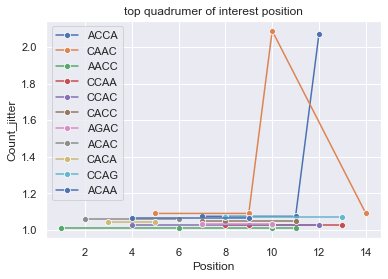

In [135]:
for i in top_5_quadrumers_of_interest['Quad']:
    temp = top_position[top_position['Quadrumer']==i]
    temp_plot = temp['Position'].value_counts().to_frame().reset_index().rename(columns={'Position':'Count','index':'Position'})
    temp_plot['Count_jitter'] = temp_plot['Count'] + np.random.random_sample()*0.1
    sns.lineplot(x='Position',y='Count_jitter',data=temp_plot, label=i, marker="o")
plt.title('top quadrumer of interest position');

In [136]:
top_position_plot = pd.DataFrame()

for i in top_5_quadrumers_of_interest['Quad']:
    temp = top_position[top_position['Quadrumer']==i]
    temp_plot = temp['Position'].value_counts().to_frame().reset_index().rename(columns={'Position':'Count','index':'Position'}).sort_values('Position')
    temp_plot['Count_jitter'] = temp_plot['Count'] + np.random.random_sample()*0.08
    temp_plot['Quad'] = [i for x in range(len(temp_plot))]
    top_position_plot = top_position_plot.append(temp_plot)
    
fig = px.line(top_position_plot, x="Position", y="Count_jitter",color='Quad',title='top quadrumer of interest position')
fig.show()

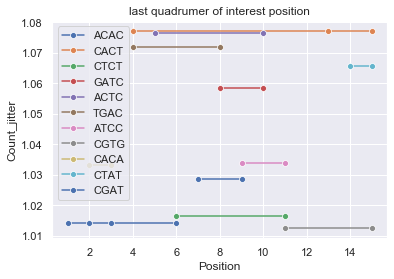

In [137]:
last_position = pd.DataFrame()
for seq in last_5['Sequence']:
    last_position = last_position.append(quadrumer_with_position(seq),ignore_index=True)

for i in last_5_quadrumers_of_interest['Quad']:
    temp = last_position[last_position['Quadrumer']==i]
    temp_plot = temp['Position'].value_counts().to_frame().reset_index().rename(columns={'Position':'Count','index':'Position'})
    temp_plot['Count_jitter'] = temp_plot['Count'] + np.random.random_sample()*0.08
    sns.lineplot(x='Position',y='Count_jitter',data=temp_plot, label=i, marker="o")
plt.title('last quadrumer of interest position');


last_position_plot = pd.DataFrame()

for i in last_5_quadrumers_of_interest['Quad']:
    temp = last_position[last_position['Quadrumer']==i]
    temp_plot = temp['Position'].value_counts().to_frame().reset_index().rename(columns={'Position':'Count','index':'Position'}).sort_values('Position')
    temp_plot['Count_jitter'] = temp_plot['Count'] + np.random.random_sample()*0.08
    temp_plot['Quad'] = [i for x in range(len(temp_plot))]
    last_position_plot = last_position_plot.append(temp_plot)
    
fig = px.line(last_position_plot, x="Position", y="Count_jitter",color='Quad',title='Last quadrumer of interest position')
fig.update_layout(yaxis_range=[0,3])
fig.show()

In [138]:
# top quadrumers of interest exist in last
top_5_quadrumers_of_interest['Occurred in last?'] = top_5_quadrumers_of_interest['Quad'].isin(last_5_quadrumers['Quad'])
top_5_quadrumers_of_interest['Occurred in last of interest?'] = top_5_quadrumers_of_interest['Quad'].isin(last_5_quadrumers_of_interest['Quad'])

top_5_quadrumers_of_interest

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Quad,Count,Occurred in last?,Occurred in last of interest?
0,ACCA,6,False,False
1,CAAC,5,False,False
2,AACC,4,False,False
3,CCAA,3,False,False
4,CCAC,3,True,False
5,CACC,3,False,False
6,AGAC,2,False,False
7,ACAC,2,True,True
8,CACA,2,True,True
9,CCAG,2,False,False


In [139]:

last_5_quadrumers_of_interest['Occurred in top?'] = last_5_quadrumers_of_interest['Quad'].isin(top_5_quadrumers['Quad'])
last_5_quadrumers_of_interest['Occurred in top of interest?'] = last_5_quadrumers_of_interest['Quad'].isin(top_5_quadrumers_of_interest['Quad'])

last_5_quadrumers_of_interest

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Quad,Count,Occurred in top?,Occurred in top of interest?
0,ACAC,4,True,True
1,CACT,3,True,False
2,CTCT,2,False,False
3,GATC,2,True,False
4,ACTC,2,True,False
5,TGAC,2,False,False
6,ATCC,2,True,False
7,CGTG,2,True,False
8,CACA,2,True,True
9,CTAT,2,False,False
